In [1]:
# this is the pipeline of phenotype analysis
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection as fdr
plt.rcParams['font.family'] = 'Arial'

In [2]:
def draw_all(cohort_dict, cluster, title, p_value, outpath):
    # process the data
    df = pd.DataFrame(columns=['SE', 'Phenotype'])
    phenos = list(cohort_dict.keys())
    color_dict = {'NR':'#3784BB', 'R':'#C84940'} # R for health, NR for case
    p = 'NR'
    for pheno in phenos:
        df_tmp = pd.DataFrame(columns=['SE', 'Phenotype'])
        df_tmp['SE'] = cohort_dict[pheno][cluster]
        df_tmp['Phenotype'] = pheno
        df = pd.concat([df, df_tmp])
    df.sort_values(by='SE', inplace=True)

    #fig, axes = plt.subplots(1, 5, figsize=(15, 4))
    fig = plt.figure(figsize=(15, 4))
    gs = GridSpec(1, 3, width_ratios=[1, 0.8, 2])
    
    # first plot: percentage of 0 in each phenotype
    ax = fig.add_subplot(gs[1])
    health_total = len(cohort_dict['R'][cluster])
    health_zero = sum(cohort_dict['R'][cluster] == 0)
    health_zero_ratio = health_zero / health_total
    case_total = len(cohort_dict[p][cluster])
    case_zero = sum(cohort_dict[p][cluster] == 0)
    case_zero_ratio = case_zero / case_total
    x = [0.7, 1.3]
    ax.bar(x, [case_zero_ratio, health_zero_ratio], color=['#CCCCCC', '#CCCCCC'], label='zero', width=0.4, edgecolor='black')
    ax.bar(x[0], bottom=[case_zero_ratio], height=[1-case_zero_ratio], color=['#3784BB'], label='non-zero', width=0.4, edgecolor='black')
    ax.bar(x[1], bottom=[health_zero_ratio], height=[1-health_zero_ratio], color=[color_dict['R']], label='non-zero', width=0.4, edgecolor='black')
    
    if case_zero_ratio > 0.9:
        ax.text(x[0], case_zero_ratio-0.05, str(case_zero), ha='center', va='center')
    else:
        ax.text(x[0], case_zero_ratio+0.05, str(case_zero), ha='center', va='center')

    if health_zero_ratio > 0.9:
        ax.text(x[1], health_zero_ratio-0.05, str(health_zero), ha='center', va='center')
    else:
        ax.text(x[1], health_zero_ratio+0.05, str(health_zero), ha='center', va='center')
    
    ax.text(x[0], 1.05, str(case_total), ha='center', va='center')
    ax.text(x[1], 1.05, str(health_total), ha='center', va='center')
    
    #ax.legend()
    plt.xticks(x, [p, 'R'])
    ax.set_xlabel('Phenotype')
    ax.set_ylabel('Propotion')
    ax.set_title('Samples with SE=0')
    ax.set_ylim(0, 1.2)
    ax.set_xlim(0.3, 1.7)

    # second plot: boxplot of SE
    category_order = [p, 'R']
    ax = fig.add_subplot(gs[0])
    sns.violinplot(x='Phenotype', y='SE', data=df, ax=ax, dodge=False,
                    palette=color_dict,
                    scale="width", inner=None,order=category_order)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    for violin in ax.collections:
        bbox = violin.get_paths()[0].get_extents()
        x0, y0, width, height = bbox.bounds
        violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax.transData))
    sns.boxplot(x='Phenotype', y='SE', data=df, ax=ax, saturation=1, showfliers=False,
            width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'},order=category_order)
    old_len_collections = len(ax.collections)
    sns.stripplot(x='Phenotype', y='SE', data=df, ax=ax, palette=color_dict, dodge=False,order=category_order)
    for dots in ax.collections[old_len_collections:]:
        dots.set_offsets(dots.get_offsets() + np.array([0.12, 0]))    
        ax.set_ylim(ylim)
    #sns.boxplot(x='Phenotype', y='SE', data=df, ax=ax, palette=color_dict, width=0.5, order=category_order)
    ax.set_xlabel('Phenotype')
    ax.set_ylabel('SE')
    ax.set_title('SE distribution\n(p = {:.4f})'.format(p_value))
    

    # third plot: scatter plot of SE without 0
    df_nonzero = df[df['SE'] != 0]
    df_nonzero.reset_index(inplace=True)
    ax = fig.add_subplot(gs[2])
    ax.scatter(np.arange(len(df_nonzero))+1, df_nonzero['SE'], c=[color_dict[i] for i in df_nonzero['Phenotype']], s=10)
    case_legend = plt.Line2D([], [], marker='o', color='#C84940', label=p)
    control_legend = plt.Line2D([], [], marker='o', color=color_dict['R'], label='R')
    #ax.legend(handles=[case_legend, control_legend])
    ax.set_ylabel('SE')
    ax.set_ylim(ylim)
    ax.set_xlabel('Samples')
    ax.set_title('Excluding SE = 0')
    ax.yaxis.set_ticklabels([]) 

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=300, format='svg')


In [3]:
def non_zero_test(cohort_dict, cluster):
    phenos = list(cohort_dict.keys())
    v1 = list(cohort_dict[phenos[0]][cluster])
    v2 = list(cohort_dict[phenos[1]][cluster])
    non_zero_v1 = [x for x in v1 if x > 0]
    non_zero_v2 = [x for x in v2 if x > 0]
    if len(non_zero_v1)==0 or len(non_zero_v2)==0:
        return False, -1
    stat, p = mannwhitneyu(non_zero_v1, non_zero_v2)
    return True, p

def non_zero_test_all(cohort_dict, p_df, cohort):
    new_p_df = pd.DataFrame(columns=p_df.columns)
    valid_cluster = []
    for cluster in p_df.columns:
        zero_p = p_df.loc[cohort, cluster]
        if zero_p<0:
            continue
        valid, p = non_zero_test(cohort_dict, cluster)
        new_p_df.loc[cohort, cluster] = p
        if valid:
            valid_cluster.append(cluster)
    # adjust p value
    new_p_df.loc[cohort, valid_cluster] = fdr(new_p_df.loc[cohort, valid_cluster])[1]
    return new_p_df, valid_cluster

<ipython-input-2-eae3b164fd03>:67: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='Phenotype', y='SE', data=df, ax=ax, palette=color_dict, dodge=False,order=category_order)
<ipython-input-2-eae3b164fd03>:67: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='Phenotype', y='SE', data=df, ax=ax, palette=color_dict, dodge=False,order=category_order)


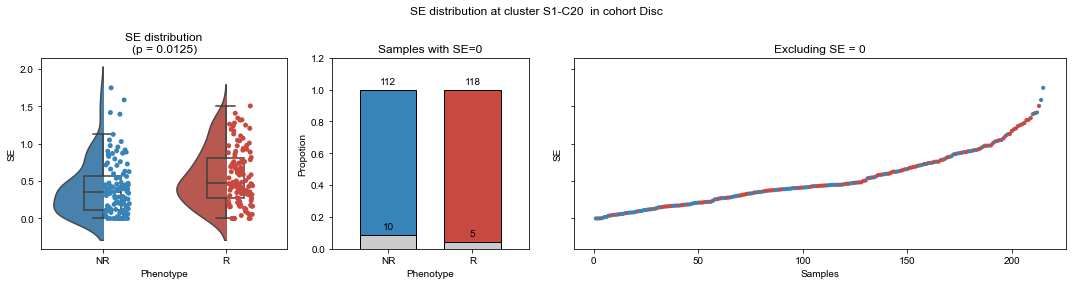

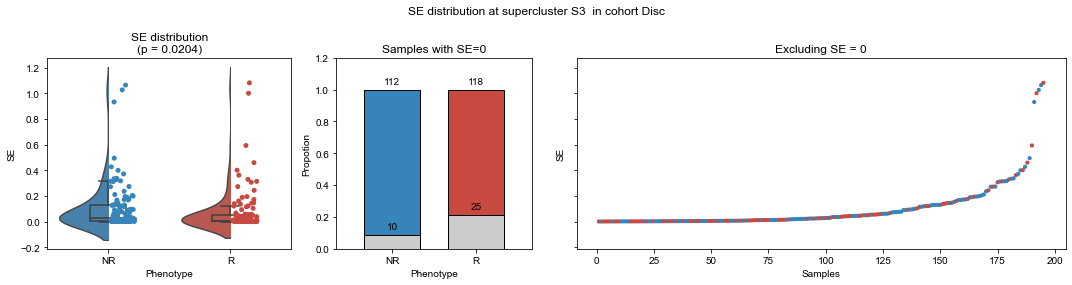

In [4]:
outer = '../result/immu/SE'
outdir = '../result/immu/SE_distribution'

p_df = pd.read_csv(os.path.join(outer,'p_all_cohorts.tsv'), sep='\t', index_col=0, header=0)
p_df.fillna(-1, inplace=True)

for cohort in os.listdir(outer):
    if '.' in cohort:
        continue
    project_dir = os.path.join(outer, cohort)
    cohort_dict = {}
    for file in os.listdir(project_dir):
        filepath = os.path.join(project_dir, file)
        df = pd.read_csv(filepath, sep='\t', index_col=0, header=0)
        pheno = file.split('.')[0].split('_')[-1]
        cohort_dict[pheno] = df
    #new_p_df, valid_cluster = non_zero_test_all(cohort_dict, p_df, project)
    for cluster in p_df.columns:
        #cluster = 'cluster_S1-C20'
        #cluster = 'cluster_C8'
        p_value = p_df.loc[cohort, cluster]
        if p_value<0 or p_value>0.05:
            continue
        title = 'SE distribution at {}  in cohort {}'.format(cluster.replace('_', ' '), cohort)
        #title = '{} at {}'.format(project, cluster)
        p_value = p_df.loc[cohort, cluster]
        odir = os.path.join(outdir, cluster)
        if not os.path.exists(odir):
            os.makedirs(odir)
        outpath = os.path.join(odir, '{}.svg'.format(cohort))
        draw_all(cohort_dict, cluster, title, p_value, outpath)
        #draw_cohort(cohort_dict, cluster, '{} at {}'.format(project, cluster))